# Numerically Controlled Oscillator (NCO) and Direct Digital Synthesis (DDS)

In [78]:
import numpy as np
import matplotlib.pyplot as plt

from rfproto import measurements, nco, plot

## NCO Basics and Characteristics

A Numerically Controlled Oscillator (NCO) is a way to digitally- and efficiently- generate sinusoidal signals. It has a basic structure consisting of:
* Input phase increment value, $\Delta\theta$, or _Frequency Control Word (FCW)_, which controls how quickly the phase rotates per clock cycle. Like a phasor, the speed at which phase rotates is related to the _frequency_ of the resulting sinusoid.
* A _phase accumulator_ stage which adds the PCW each cycle. Again similar to a phasor, this acts as the integrator of phase (as frequency is the integral of phase). The phase accumulator is a fixed-point integer that is expected to roll-over back to 0 beyond its terminal value, similar to phase being bounded from $0\rightarrow 2\pi$. In this way, an $N$ bit-long phase accumulator represents 0 radians when equal to 0, and $2\pi$ radians when equal to $2^{N}-1$.
* A _phase truncation_ (or quantizer) stage which takes the $P$ most-significant-bits from the phase accumulator to form the lookup table (LUT) index. $P$ is equal to the number of address bits in the associated wave LUT (or read-only memory (ROM)). $P$ is often much smaller than the phase accumulator length $N$, such that the associated LUT size is not prohibitively large. However, the phase trunctation process introduces periodic phase errors in the output, causing a form of spurious output noise.
* A LUT which takes an index/address and outputs an associated output sample value. This LUT is nominally filled with the full-cycle of a sinusoid, such that the input address represents the associated phase for a given output value. In this way, the LUT is also known as a _phase-to-amplitude_ converter. The LUT samples have a quantized value of $M$ bits, representing the signed, fixed-point integer values of the sinusoid's amplitude at the associated phase value/index. The quantization of a fixed point value to $M$ bits also causes a form of output noise, compared to ideal sinusoidal value.

![image.png](attachment:4751cfec-e917-496e-8e45-1334dd363e92.png)

In [92]:
f  = 3000 # desired output frequency
n  = 2**16 # number of output points to compute (power of 2 for FFTs)
fs = 48000 # sampling frequency
N  = 10    # phase accumulator length (num bits)
P  = 6   # LUT table address length (total depth = 2^P)
M  = 24    # quantized word length (num bits)

The estimated Spurius-Free Dynamic Range (SFDR) is based on the amount of Sine samples in the pre-determined look-up table (LUT). This LUT depth can be expressed in how many bits ($P$) it takes to address all samples in a LUT (e.g. total samples equals $2^N$ address bits):
$$ \text{SFDR (dB)} = 6.02P - 3.92 $$
The esimated Noise Floor is mainly driven on the amount of quantization of our Sine samples in the LUT; the higher the number of bits of our samples ($M$), the less quantization noise:
$$ \text{Noise Floor (dBFS)} = 6.02M + 1.76 $$

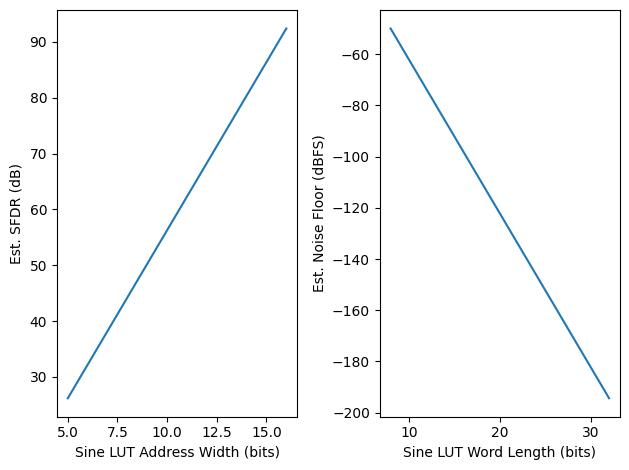

In [93]:
plt.subplot(1,2,1)
SFDR_range = [(6.02*P)-3.92 for P in range(5,17)]
plt.plot(list(range(5,17)),SFDR_range)
plt.xlabel("Sine LUT Address Width (bits)")
plt.ylabel("Est. SFDR (dB)")
plt.subplot(1,2,2)
noise_range = [-measurements.ideal_SNR(M) for M in range(8,33)]
plt.plot(list(range(8,33)),noise_range)
plt.xlabel("Sine LUT Word Length (bits)")
plt.ylabel("Est. Noise Floor (dBFS)")
plt.tight_layout()

The frequency resolution of DDS's are excellent given the ease of using a phase accumulator with a nominal word length (e.x. 32 bits) to keep track of the phase that the DDS should transform into sinusoid samples. The frequency resolution of a given phase accumulator can be given by the number of bits for the accumulator ($N$) and the sampling (or DDS synchronous) frequency ($F_{s}$):
$$ \text{Frequency Resolution (Hz)} = \frac{F_{s}}{2^N} $$

In [94]:
print("Frequency Resolution: {:.6f} Hz".format(fs/(2**N)))

Frequency Resolution: 0.000011 Hz


The amount to increment the phase accumulator, $\Delta\theta$, by each clock cycle, to get a specific output frequency ($f_{o}$) can be found by:
$$ \Delta\theta = f_{o}\frac{2^N}{F_{s}} $$
This is also known as the tuning of Frequency Control Word (FCW).

The Sine Look-Up Table (LUT) can be generated given a LUT address length ($P$) and the desired output signed-integer bitwidth ($M$); essentially, one full cycle of a sine wave is generated and quantized to the full-scale sample vale.

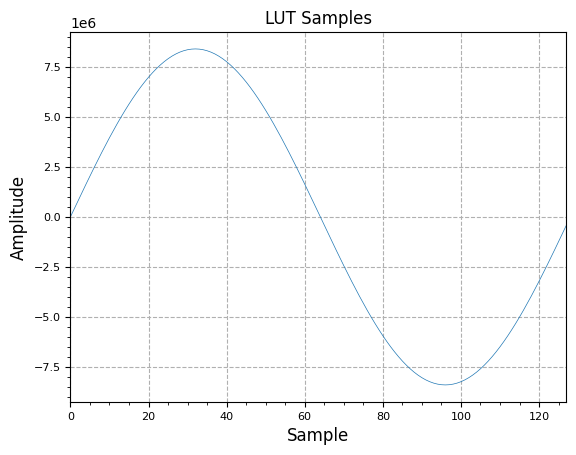

In [95]:
test_NCO = nco.Nco(N, M, P, fs)
plot.samples(test_NCO.LUT.imag, "LUT Samples")
plt.show()

The DDS output can now be created at each clock cycle by:
* Incrementing the phase accumulator by our previously determined $\Delta\text{Phase}$ value
* Using the upper $P$ bits of the phase accumulator (right-shift phase accumulator by $N-P$ bits) to directly address the pre-generated Sine LUT, which gives the the output value

In [96]:
y = np.zeros(n)    # initialize output sample vector (statically sized)
test_NCO.SetOutputFreq(f)
for i in range (n):
    # just take imag part (starts at 0) for this
    y[i] = test_NCO.Step().imag

The sample outputs of the DDS can be shown below:

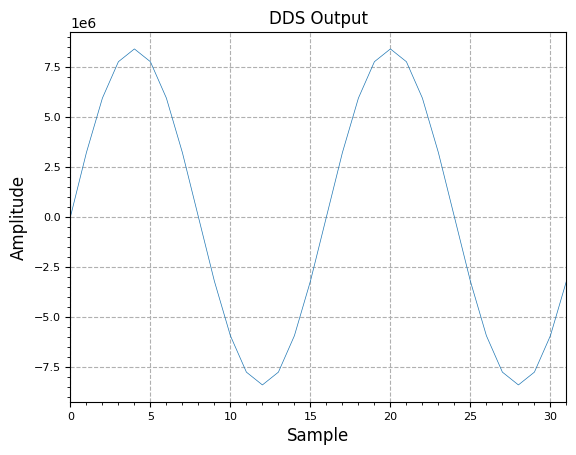

In [97]:
plot.samples(y[0:int(2*fs/f)], "DDS Output")
plt.show()

The DDS Output Spectrum can be shown as

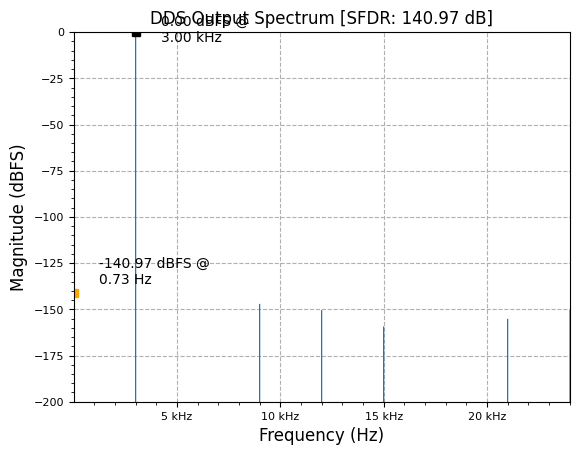

In [98]:
plot.spec_an(y, fs, "DDS Output Spectrum", scale_noise=True, norm=True)
plt.ylim(-200, 0)
plt.show()

## Quarter-Wave LUT NCO

Since the full period of a sine wave is symmetrical, only 1/4 of the total sinusoid's sample values need to be stored in the LUT.

![image.png](attachment:d8cd2fb3-048e-4d71-b6af-0bfa2f726ceb.png)

In this case, the associated phase can determine how to index into the LUT table and/or invert the LUT output to create a full period sine wave:
$$ y_{NCO}(\theta)=
\begin{cases}
    \text{ LUT}[\theta],& 0 \leq \theta < \pi/4 \\
    \text{ LUT}[\pi - \theta],& \pi/4 \leq \theta < \pi/2 \\
    -\text{LUT}[\theta - \pi],& \pi/2 \leq \theta < 3\pi/4 \\
    -\text{LUT}[2\pi - \theta],& 3\pi/4 \leq \theta < 2\pi \\
\end{cases}$$

In [ ]:
quart_NCO = nco.Nco(N, M, P, fs, quarter_wave=True)
plot.samples(quart_NCO.LUT.imag, "LUT Samples")
plt.show()

In [ ]:
y = np.zeros(n)    # initialize output sample vector (statically sized)
quart_NCO.SetOutputFreq(f)
for i in range (n):
    # just take imag part (starts at 0) for this
    y[i] = quart_NCO.Step().imag

plot.samples(y[0:int(2*fs/f)], "DDS Output")
plt.show()

In [ ]:
plot.spec_an(y, fs, "1/4 Wave DDS Output Spectrum", scale_noise=True, norm=True)
plt.show()

## Phase Dithering

Periodic phase truncation/quantization effects cause spurs in the total spectrum. Near-in phase noise can be traded for lower far-out spurs and total SFDR by dithering (adding some random bits of noise) the phase accumulator.

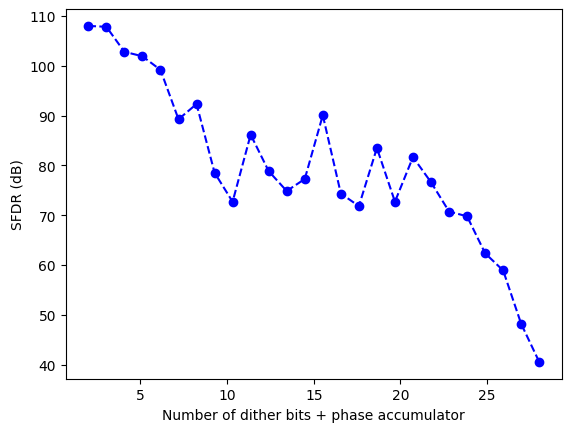

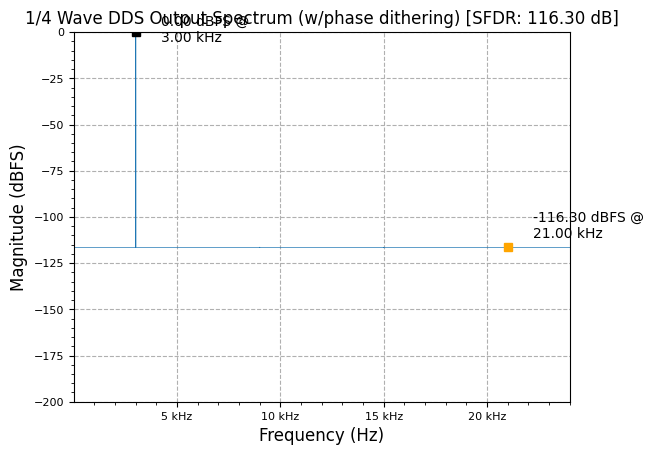

Best SFDR at 2 bits of added dither, given phase acc. length of 32 bits and 7 LUT address bits


In [99]:
dither_SFDR = []
y_dith = np.zeros(n)
max_SFDR = 0
max_SFDR_bits = 0

for dither_bits in range(2, N - 4):
    dith_NCO = nco.Nco(N, M, P, fs, quarter_wave=True, dither=True, dither_bits=dither_bits)
    dith_NCO.SetOutputFreq(f)
    for i in range (n):
        y_dith[i] = np.imag(dith_NCO.Step())
    dSFDR = measurements.SFDR(y_dith, fs, norm=True)
    meas_SFDR = dSFDR["SFDR"]
    dither_SFDR.append(meas_SFDR)
    if meas_SFDR > max_SFDR:
        max_SFDR = meas_SFDR
        max_SFDR_bits = dither_bits

plt.plot(np.linspace(2, N-4, len(dither_SFDR)), dither_SFDR, '--bo')
plt.xlabel("Number of dither bits + phase accumulator")
plt.ylabel("SFDR (dB)")
plt.show()

dith_NCO = nco.Nco(N, M, P, fs, quarter_wave=True, dither=True, dither_bits=max_SFDR_bits)
dith_NCO.SetOutputFreq(f)
for i in range (n):
    y_dith[i] = np.imag(dith_NCO.Step())
plot.spec_an(y_dith, fs, "1/4 Wave DDS Output Spectrum (w/phase dithering)", scale_noise=True, norm=True)
plt.ylim(-200, 0)
plt.show()

print(f"Best SFDR at {max_SFDR_bits} bits of added dither, given phase acc. length of {N} bits and {P} LUT address bits")

## Taylor Series

The [Taylor Series expansion](https://en.wikipedia.org/wiki/Taylor_series) is a powerful method to decompose a function into an infinite sum of terms that are experessed in terms of a the function's derivatives at a single point. As such, the [Taylor series of trigonometric functions](https://en.wikipedia.org/wiki/Taylor_series#Trigonometric_functions) can be used to approximate a $\sin()$ function as:
$$ \sin(\theta) = \sum_{n=0}^{\infty}\frac{(-1)^{n}}{(2n + 1)!}\theta^{2n + 1} \rightarrow \theta - \frac{\theta^{3}}{3!} + \frac{\theta^{5}}{5!} - \frac{\theta^{7}}{7!}\dots,\quad \text{for all }\theta \text{ (Radians)}$$
$$ \cos(\theta) = \sum_{n=0}^{\infty}\frac{(-1)^{n}}{(2n)!}\theta^{2n} \rightarrow 1 - \frac{\theta^{2}}{2!} + \frac{\theta^{4}}{4!} - \frac{\theta^{6}}{6!}\dots,\quad \text{for all }\theta \text{ (Radians)}$$

In [ ]:
def factorial(x):
    if x > 1:
        return x * factorial(x-1)
    else:
        return 1

def sin_ts(x):
    p3 = (x**3)/(factorial(3))
    p5 = (x**5)/(factorial(5))
    p7 = (x**7)/(factorial(7))
    # 11th order gives diminishing results in output precision...
    #p11 = (x**11)/(factorial(11))
    return x - p3 + p5 - p7

def sin_ts_compress(x):
    if x < np.pi / 2:
        return sin_ts(x)
    elif x < np.pi:
        return sin_ts(np.pi - x)
    elif x < 3 * np.pi / 2:
        return -sin_ts(x - np.pi)
    else: # < 2*pi
        return -sin_ts(2*np.pi - x)

num_compares = 1000
sin_err = np.zeros(num_compares)
comp_sin_err = np.zeros(num_compares)
for i in range(num_compares):
    theta = 2 * np.pi * (i/num_compares)
    ref = np.sin(theta)
    taylor = sin_ts(theta)
    comp_taylor = sin_ts_compress(theta)
    if ref != 0.0:
        sin_err[i] = abs(100.0 * (ref - taylor)/ref)
        comp_sin_err[i] = abs(100.0 * (ref - comp_taylor)/ref)
    else:
        sin_err[i] = 0.0
        comp_sin_err[i] = 0.0
    if comp_sin_err[i] > 0.1:
        print(f"Annomaly at [theta = {theta} rads] ref = {ref} | comp = {comp_taylor}")

plt.plot(np.linspace(0, 2*np.pi, num_compares), sin_err, label="Taylor series")
plt.plot(np.linspace(0, 2*np.pi, num_compares), comp_sin_err, label="Taylor series (folded)")
plt.xlabel("x (Radians)")
plt.ylabel("% Error")
plt.ylim((0, 0.1))
plt.legend()
plt.show()

It can be seen that Taylor Series is very accurate for small angles/phase, but starts to be very innacurate as phase approaches (and exceeds) $\pi/2$ Radians. However, the use of a couple multiplies to find a very accurate $\sin()$ and $\cos()$ value at small phase angles can be exploited for a _Taylor-Series Corrected NCO_.

As seen from the phase-dithered NCO, the main source of spurs is from the phase truncation process of keeping only the $N - P$ MSBs of the phase accumulator to index the LUT. If the phase accumulator matched the LUT address size completely, there would be no spurs and only quantization noise from the discrete sinusoid samples stored in the LUT. However, this is often impractical for many applications as it would require either:
* An impractically large LUT size for a phase accumulator with enough precision for fine frequency output control or
* An impractically small output frequency resolution if a small enough phase accumulator width was chosen to match a practical LUT address size. For example, a system where $F_{s}=100\text{MHz}$ and $N = P = 10$ bits, would have a very coarse output frequency resolution of almost $100\text{kHz}$. However, for some systems this may be OK!

For NCOs used in applications like Digital Down Converters (DDCs) though, having high sprectral purity and high frequency precision is critical, as each spur acts like a separate mixer in this case! A fundamental way to think of the issue is to notice that the phase accumulator represents a given phase angle $\theta$ at any time with a range of $0 \rightarrow 2\pi$. When truncated, the "dropped" LSBs of the phase accumulator represent the unaccounted phase error, $\theta_{err}$, as the LUT is indexed with the rounded/truncated MSBs representing $\theta_{LUT}$. Since $\theta = \theta_{err} + \theta_{LUT}$, we can exploit the [trigonometric identities of angle sums](https://en.wikipedia.org/wiki/List_of_trigonometric_identities#Angle_sum_and_difference_identities) to use the dropped phase error $\theta_{err}$ in creating a full-precision sinusoidal output (and for both real and imaginary outputs of the NCO):
$$\sin(\theta_{LUT} + \theta_{err}) = \sin(\theta_{LUT})\cos(\theta_{err}) + \cos(\theta_{LUT})\sin(\theta_{err})$$
$$\cos(\theta_{LUT} + \theta_{err}) = \cos(\theta_{LUT})\cos(\theta_{err}) - \sin(\theta_{LUT})\sin(\theta_{err})$$

While it can be seen that applying the correction is rather trivial, even for digital hardware implementations (it's a couple multiplies and two addition/subtraction operations), now the issue is how to compute the values $\sin(\theta_{err})$ and $\cos(\theta_{err})$.

One way that has been discussed before is to use the [small-angle approximation](https://en.wikipedia.org/wiki/Small-angle_approximation) (e.g. $\sin(\theta) \approx \theta$) to simply feed-forward the truncated LSBs to the angle sum and difference output, as $\theta_{err}$ is always a relatively small angle. However, in simulation, this still does not result in the best output spectrum.

Another method is to compute $\sin(\theta_{err})$ and $\cos(\theta_{err})$ using a second (and sometimes third) look-up table indexed by the truncated bits. This method uses more memory (for the additional LUTs), but can still be prohibitive if the truncated phase is still large. However in this case, a third LUT is usually added, for example to break up a 32 bit phase accumulator into: a primary 12 bit LUT, 10 bit secondary and 10 bit final LUTs. This approach still requires multipliers and addition circuits to implement the angle sum and difference though.

Given modern devices with many multiplier circuits, and the fact that Taylor-Series Approximation is very accurate for small phase angles, we can use a 2nd Order $\sin()$ and $\cos()$ approximation to get and apply the $\sin(\theta_{err})$ and $\cos(\theta_{err})$ values.

In [ ]:
# TODO: figure out why Taylor Series correction- even floating-point model- has issues in 1/4 wave mode, likely due to
#  LUT index being different than straight phase_acc truncation
taylor_NCO = nco.Nco(N, M, P, fs, quarter_wave=False, dither=False, taylor_corr=True)
taylor_NCO.SetOutputFreq(12200)
#n = 100
y_taylor = np.zeros(n) + 1j*np.zeros(n)
for i in range (n):
    y_taylor[i] = taylor_NCO.Step()
plot.spec_an(y_taylor, fs, "Taylor Series NCO", scale_noise=True, norm=True)
plt.show()

Now there are no obvious spurs in the output spectrum and the noise floor is at the limit of the given quantization level of the LUT samples!

Note that phase accumulator dithering is also now moot and can be seen to have no effect on the output spectrum. The phase noise spreading effect of dithering is not necessary with Taylor Series correction of truncated phase.

## References

* [DDS - Wireless Pi](https://wirelesspi.com/direct-digital-synthesizer-dds/)
* [DDS Compiler v6.0 - AMD-Xilinx](https://docs.xilinx.com/v/u/en-US/pg141-dds-compiler)
  + [Older v5.0 doc](https://docs.xilinx.com/v/u/en-US/dds)
* [Building a Quarter sine-wave LUT](https://zipcpu.com/dsp/2017/08/26/quarterwave.html)
* [High Precision Sine Wave Synthesis Using Taylor Series](https://www.pjrc.com/high-precision-sine-wave-synthesis-using-taylor-series/)
  + [Fast fixed-point sine approximations](https://www.coranac.com/2009/07/sines/)
* [A Technical Tutorial on DDS - ADI](https://www.ieee.li/pdf/essay/dds.pdf)
* [Ultra Low Phase Noise DDS - fred harris & Chris Dick](https://www.wirelessinnovation.org/assets/Proceedings/2006/sdr06-1.3-01-harris.pdf)
  + [Ultra Low Phase Noise DSP Oscillator (DSP Tips & Tricks)](https://ieeexplore.ieee.org/document/4286572)
* [DDS - Wikipedia](https://en.wikipedia.org/wiki/Direct_digital_synthesis)
  + [NCO - Wikipedia](https://en.wikipedia.org/wiki/Numerically_controlled_oscillator)
* [All about DDS - ADI](https://www.analog.com/en/analog-dialogue/articles/all-about-direct-digital-synthesis.html)
* [DDS - Supersampling about the FPGA clock frequency](https://dsp.stackexchange.com/questions/63887/dds-supersampling-above-the-fpga-clock-frequency)
* [How to Achieve Frequency Hopping With the AFE79xx](https://www.ti.com/lit/an/sbaa443/sbaa443.pdf)
* [Improving SFDR in a Python DDS Model](https://cushychicken.github.io/improving-sfdr-in-python-direct-digital-synthesizer/)
* [FPGA Sine LUT - Project F](https://projectf.io/posts/fpga-sine-table/)
* [Reducing ADC Quantization Noise - Dithering](https://www.mwrf.com/technologies/components/article/21846556/reducing-adc-quantization-noise)
* [Direct Digital Frequency Synthesizer with CORDIC Algorithm and Taylor Series Approximation for Digital Receivers](https://hal.science/hal-00516790/document)
* [Taylor-Series-Based Reconfigurability of Gamma Correction in Hardware Designs](https://www.mdpi.com/2079-9292/10/16/1959)